# Demo of graph optimisation on real graph to segment structures:

# TODO: implement edge classification predictions just as in the dummy graph:

In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


In [2]:
import torch
import torch_geometric

from scipy.special import softmax
from sklearn.manifold import TSNE


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <B5FD9895-F13C-386E-85C3-E2998159857E> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while imp

In [3]:
from grace.base import GraphAttrs, Annotation
from grace.io.image_dataset import ImageGraphDataset

# from grace.simulator.simulate_graph import random_graph, random_graph_mixed_motifs
from grace.simulator.simulate_image import montage_from_image
from grace.models.feature_extractor import FeatureExtractor
from grace.models.datasets import dataset_from_subgraphs, dataset_from_whole_graph
from grace.models.optimise import optimise_graph


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <6A7076EE-85BD-37A7-BC35-1D4867F2B3D3> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load an example image + build graph:

In [4]:
# IMAGE_DIR = "/Users/kulicna/Desktop/classifier/data_real/"
IMAGE_DIR = "/Users/kulicna/Desktop/classifier/data_fake/infer/padded/"
IMAGE_DIR, os.path.isdir(IMAGE_DIR)

('/Users/kulicna/Desktop/classifier/data_fake/infer/padded/', True)

In [5]:
IMAGE_FN = os.path.join(IMAGE_DIR, "MRC_Synthetic_File_000.mrc")
IMAGE_FN, os.path.isfile(IMAGE_FN)

('/Users/kulicna/Desktop/classifier/data_fake/infer/padded/MRC_Synthetic_File_000.mrc',
 True)

In [6]:
# import mrcfile

# with mrcfile.open(IMAGE_FN, "r") as mrc:
#     # image_data = mrc.data.astype(int)  # works
#     image_data = mrc.data

In [7]:
# image_data.shape, image_data.dtype, np.unique(image_data)

In [8]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGE_DIR,
    grace_dir=IMAGE_DIR,
    transform=lambda x,y: (x,y),
    image_filetype="mrc",
)
image_graph_dataset

In [9]:
for image, graph_data in image_graph_dataset:
    #image = image.T
    print (image.shape, image.dtype, np.unique(image), graph_data.keys(), graph_data)


MRC_Synthetic_File_000
torch.Size([3948, 3948]) torch.float32 [0.  0.5 1. ] dict_keys(['graph', 'metadata']) {'graph': <networkx.classes.graph.Graph object at 0x7fd7c1328e80>, 'metadata': {'image_filename': 'MRC_Synthetic_File_000'}}


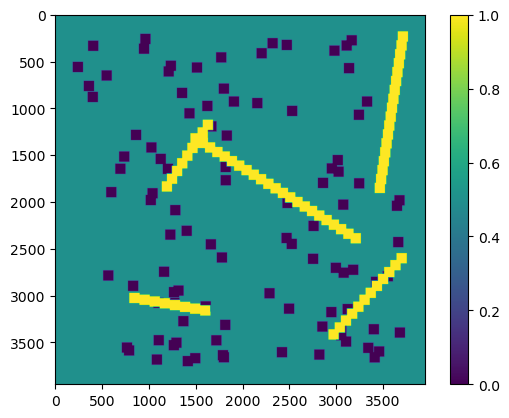

In [10]:
plt.imshow(image)
plt.colorbar()
plt.show()

In [11]:
image.dtype, image.max(), image.min()

(torch.float32, tensor(1.), tensor(0.))

In [12]:
graph = graph_data['graph']
graph.number_of_nodes(), graph.number_of_edges()


(170, 495)

In [13]:
single_node = graph.nodes()[0]
single_node

{<GraphAttrs.NODE_X: 'x'>: 1652.398193359375,
 <GraphAttrs.NODE_Y: 'y'>: 1205.2373046875,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

In [14]:
pos = {idx: [node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]] for idx, node in graph.nodes(data=True)}
len(pos)

170

In [15]:
coords_x, coords_y = np.transpose(list(pos.values()))
coords_x.shape, coords_y.shape

((170,), (170,))

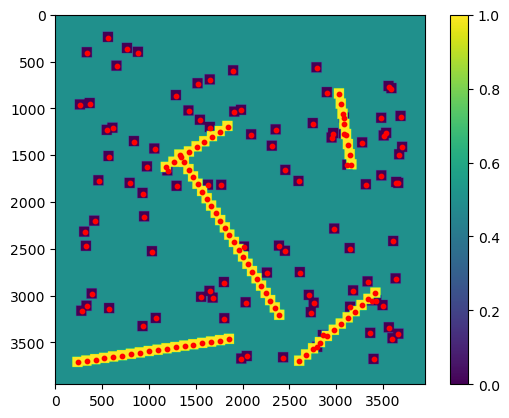

In [16]:
# plt.imshow(image, cmap="binary_r")
plt.imshow(image.T)
plt.colorbar()
plt.scatter(coords_x, coords_y, color='red', s=10)
plt.show()

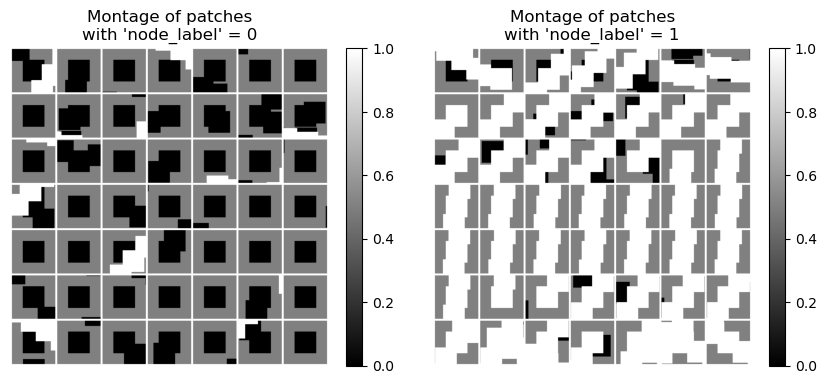

In [18]:
montage_from_image(G=graph, image=image, crop_shape=(224, 224))

### Divide by labels:

In [66]:
node_coords = [[] for _ in range(3)]

for idx, node in graph.nodes.data():
    coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]

    label = node[GraphAttrs.NODE_GROUND_TRUTH]
    node_coords[label].append(coords)

[]

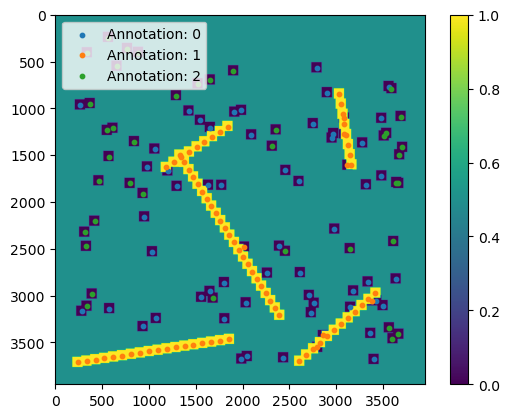

In [67]:
plt.imshow(image.T)
plt.colorbar()
for group_idx in range(len(node_coords)):
    group_data = node_coords[group_idx]
    group_data = np.array(group_data)
    plt.scatter(x=group_data[:, 0], y=group_data[:, 1], 
                s=10, label=f"Annotation: {group_idx}")
plt.legend(loc="upper left")
plt.plot()


In [68]:
# montage_from_image(G=graph, image=image, crop_shape=(224, 224))

### Now extract the features from each node patch:

In [69]:
feature_extractor = torch.load("/Users/kulicna/Desktop/classifier/extractor/resnet152.pt")
feature_extractor = FeatureExtractor(model=feature_extractor)
feature_extractor

FeatureExtractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [105]:
image, graph = feature_extractor(image=image.T, graph=graph_data)
type(image), type(graph)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Tensor, dict)

### Each node now has the feature vector appended to it:

In [106]:
graph = graph['graph']
single_node = graph.nodes()[0]
single_node, single_node[GraphAttrs.NODE_FEATURES].shape

({<GraphAttrs.NODE_X: 'x'>: 1652.398193359375,
  <GraphAttrs.NODE_Y: 'y'>: 1205.2373046875,
  <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
  <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>,
  <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.7327, 0.4982, 0.8708,  ..., 0.4318, 0.3713, 0.4708]),
  <GraphAttrs.NODE_PREDICTION: 'node_prediction'>: 0.6705986857414246},
 torch.Size([2048]))

### Can I cluster the patches by their features?

In [107]:
node_features = np.array([node[GraphAttrs.NODE_FEATURES].numpy() for _, node in graph.nodes(data=True)])
node_features.shape


(170, 2048)

In [110]:
# TODO: TSNE

tsne = TSNE(n_components=2)
embedding = tsne.fit_transform(X=node_features)
embedding.shape


(170, 2)

In [111]:
node_GT_labels = np.array([node[GraphAttrs.NODE_GROUND_TRUTH] for _, node in graph.nodes(data=True)])
node_GT_labels.shape

(170,)

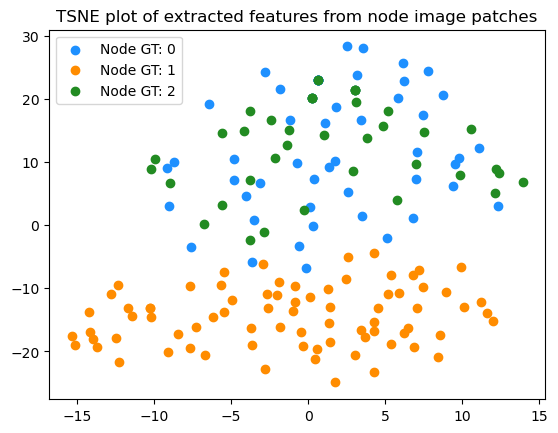

In [178]:
colors = {0: "dodgerblue", 1: "darkorange", 2: "forestgreen"}

for key in colors.keys():
    x, y = np.transpose([embedding[i] for i in range(node_GT_labels.shape[0]) if node_GT_labels[i] == key])
    plt.scatter(x=x, y=y, c=colors[key], label=f"Node GT: {key}")

plt.title("TSNE plot of extracted features from node image patches")
plt.legend()
plt.show()

In [121]:
node_GT = [0 for _ in range(3)]

for _, node in graph.nodes.data():
    node_GT[node[GraphAttrs.NODE_GROUND_TRUTH]] += 1

node_GT


[54, 77, 39]

In [122]:
edge_GT = [0 for _ in range(3)]

for st, en, edge in graph.edges.data():
    edge_GT[edge[GraphAttrs.EDGE_GROUND_TRUTH]] += 1

edge_GT

[190, 93, 212]

## Now run inference:

### Load the pre-trained models for node & edge classification:

In [123]:
classifier_model = torch.load("/Users/kulicna/Desktop/classifier/runs/2023-06-21_15-32-26/classifier.pt")
classifier_model

GCN(
  (conv1): GCNConv(2048, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (node_classifier): Linear(in_features=32, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [166]:
def get_node_predictions(G, model):
    model.eval()
    
    predictions = []
    dataset = dataset_from_subgraphs(G, n_hop=1, in_train_mode=False)
    
    for data in dataset:  # iterate in batches over the training/test dataset
        out = model(data.x, data.edge_index)
        out = out[0]  # because it's only nodes at this point you care about! out[1] = edges
        # pred = out.argmax(dim=1)
        probs = softmax(out.detach().numpy())
        predictions.append(probs)

    # this is the prediction that the node is in the object
    for (_, node), prediction in zip(G.nodes.data(), predictions):
        # for a FP, we want this to be the prob that it's *NOT* in the object
        node[GraphAttrs.NODE_PREDICTION] = np.clip(float(prediction[0, 1]), 0, 1)
        
    return G


In [167]:
def get_edge_predictions(G, model):
    model.eval()
    
    data = dataset_from_whole_graph(G)  # Data(x=[170, 2048], edge_index=[2, 495], pos=[170, 2], edge_label=[495])
    out = model(data.x, data.edge_index)
    out = out[1]  # because it's only edges at this point you care about! out[1] = edges
    # pred = out.argmax(dim=1)
    probs = softmax(out.detach().numpy())
    
    for i in range(data.edge_index.shape[-1]):
        source, target = data.edge_index[:, i].numpy()
        prediction = np.clip(float(probs[i, 1]), 0, 1)
        G[source][target][GraphAttrs.EDGE_PREDICTION] = prediction
    
    return G


In [168]:
graph = get_node_predictions(graph, classifier_model)
graph = get_edge_predictions(graph, classifier_model)
graph


### Plot the predictions of the model:

In [169]:
nodes_pred_by_group = [[single_node[GraphAttrs.NODE_PREDICTION] for _, single_node in graph.nodes.data() if single_node[GraphAttrs.NODE_GROUND_TRUTH] == anno] for anno in range(3)]
edges_pred_by_group = [[single_edge[GraphAttrs.EDGE_PREDICTION] for _, _, single_edge in graph.edges.data() if single_edge[GraphAttrs.EDGE_GROUND_TRUTH] == anno] for anno in range(3)]
[len(grp) for grp in nodes_pred_by_group], [len(grp) for grp in edges_pred_by_group]


([54, 77, 39], [190, 93, 212])

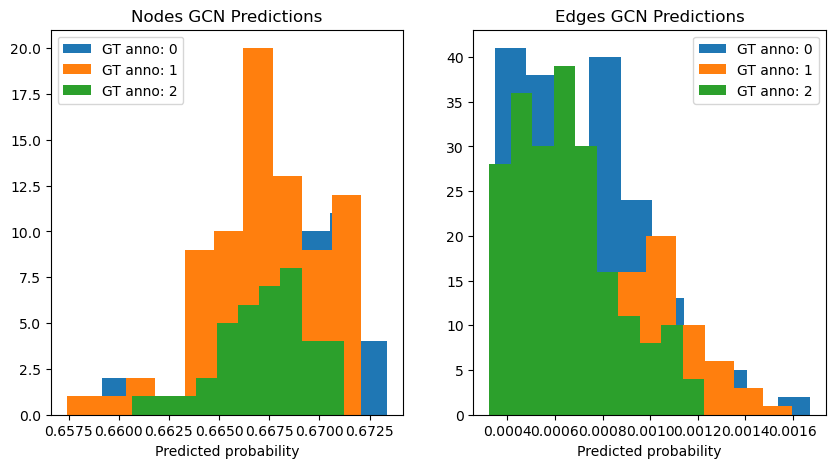

In [170]:
plt.figure(figsize=(10, 5))

for g, (graph_attribute, attribute_name) in enumerate(zip([nodes_pred_by_group, edges_pred_by_group], ["Nodes", "Edges"])):
    for anno, group in enumerate(graph_attribute):
        plt.subplot(1, 2, g+1)
        plt.hist(group, label=f"GT anno: {anno}")
        plt.title(f"{attribute_name} GCN Predictions")
        plt.xlabel("Predicted probability")
        plt.legend()
        
plt.show()
plt.close()

# Optimise a real graph:

In [171]:
x = optimise_graph(graph)

In [172]:
x.number_of_nodes(), x.number_of_edges()

(170, 0)

In [173]:
for _, node in x.nodes(data=True):
    print (node)
    break

for src, tgt, edge in x.edges(data=True):
    print (src, tgt, edge)
    break

{<GraphAttrs.NODE_X: 'x'>: 1652.398193359375, <GraphAttrs.NODE_Y: 'y'>: 1205.2373046875, <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan, <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>, <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.7327, 0.4982, 0.8708,  ..., 0.4318, 0.3713, 0.4708]), <GraphAttrs.NODE_PREDICTION: 'node_prediction'>: 0.6689684987068176}


### Visualise the graph & individual objects:

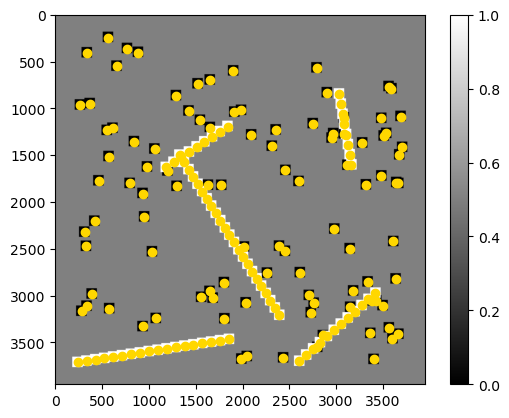

In [174]:
plt.imshow(image, cmap="binary_r")
plt.colorbar()
plt.scatter(coords_x, coords_y, color='gold')
plt.show()

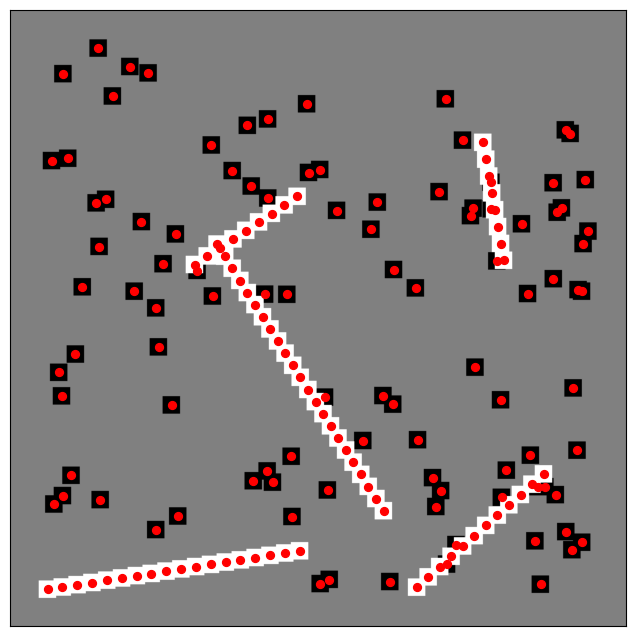

In [175]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
plt.imshow(image, cmap="binary_r")
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="r", node_size=32)
plt.show()


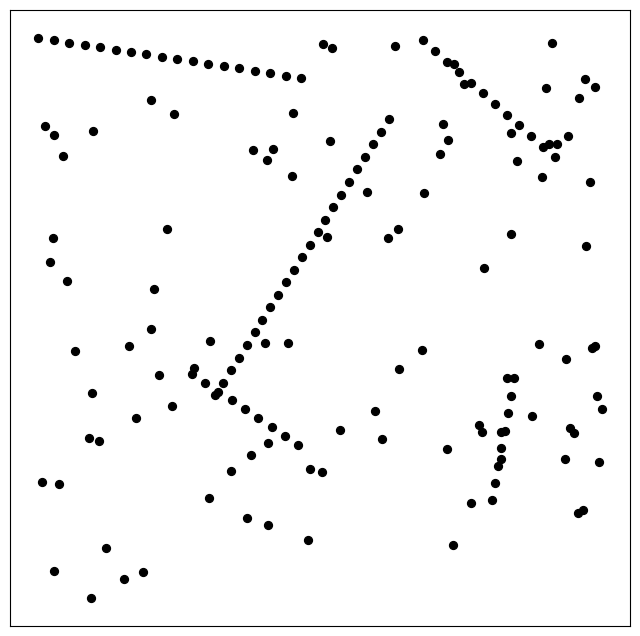

In [176]:
# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    plt.imshow(image, cmap="binary_r")
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

### Done!